# NHL Shots and Goals Analysis

### In this notebook, we have analyzed the optimal on-field player positions to maximize a team's goal scoring and defending oppurtunities.

#### Imported the required libraries

In [1]:
import json
from flatten_json import flatten
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
import matplotlib.colors as mcolors
import warnings
from IPython.display import Markdown, display
from os import system, name

warnings.filterwarnings('ignore')

### Load data

In [2]:
with open('data/shots_goals_data.json', 'r') as f:
    data = json.load(f)
record_flattened = [flatten(record) for record in data]
shot_goals_dataframe_from_json = pd.DataFrame(record_flattened)
display(shot_goals_dataframe_from_json.head())

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators


In [3]:
def display_dataset(team_a, team_b, shot_goals_dataframe):
    
    '''
        This function is used to find all the samples where shooting team is 'team_a' and defending team is 'team_b'
        or vice versa.
        
        :param team_a: Name of first NHL team
        :param team_b: Name of second NHL team
        :param shot_goals_dataframe: Name of dataframe (Superset) from which subset is to be selected
        :return filtered_dataframe: Returns the filtered (Subset) dataframe
    '''
    
    # find all the records where these teams have played
    condition = ((shot_goals_dataframe['shooting_team'] == team_a) & \
                 (shot_goals_dataframe['shot_goal_defending_team'] == team_b)) | \
    ((shot_goals_dataframe['shooting_team'] == team_b) & 
                (shot_goals_dataframe['shot_goal_defending_team'] == team_a))
    filtered_dataframe = shot_goals_dataframe[condition]
    filtered_dataframe.head()
    return filtered_dataframe

### Goal Conversion Ratio

In [4]:
def calculate_goal_conversion_ratio(team_a, team_b, filtered_dataframe):
    
    '''
        This function is used to obtain the goal conversion ratio of 'team_a' versus 'team_b' and segregate goals
        and shots from the dataframe.
        
        :param team_a: Name of the team which is scoring the goals
        :param team_b: Name of the team which is conceding the goals
        :param filtered_dataframe: Dataframe which has samples of only team_a and team_b
        :return shots_from_filtered_dataframe: Returns samples which has shots as event
        :return goals_from_filtered_dataframe: Returns samples which has goals as event
    '''
    
    team_a_shots_condition = ((filtered_dataframe['shooting_team'] == team_a) & \
                              (filtered_dataframe['event_type'] == 'Shot'))
    team_a_goals_condition = ((filtered_dataframe['shooting_team'] == team_a) & \
                              (filtered_dataframe['event_type'] == 'Goal'))
    shots_from_filtered_dataframe = filtered_dataframe[team_a_shots_condition]
    goals_from_filtered_dataframe = filtered_dataframe[team_a_goals_condition]

    total_attempts = shots_from_filtered_dataframe.shape[0] + goals_from_filtered_dataframe.shape[0]
    total_goals = goals_from_filtered_dataframe.shape[0]
    goal_conversion_ratio = (total_goals / total_attempts) * 100 
    display(Markdown('### The goal conversion ratio of \'{}\' against \'{}\' is {}%'.format(team_a, team_b, \
                                                                             round(goal_conversion_ratio,2))))
    return (shots_from_filtered_dataframe, goals_from_filtered_dataframe)

### Find Hexbins for shots and goals

In [5]:
def plot_hexbin_shots_goals(shots_from_filtered_dataframe, goals_from_filtered_dataframe):
    
    '''
        This function is used to plot the shots and goals of 'team_a' versus 'team_b'
        
        :param shots_from_filtered_dataframe: Filtered Dataframe ('team_a' versus 'team_b') which has shots as event
        :param goals_from_filtered_dataframe: Filtered Dataframe ('team_a' versus 'team_b') which has goals as event
        :return shots_hexbin_offsets: Returns x, y positions of the hexagon centers for shots plot 
        :return shots_hexbin_values: Returns number of points in the hexagon for shots plot
        :return goals_hexbin_offsets: Returns x, y positions of the hexagon centers for goals plot
        :return goals_hexbin_values: Returns number of points in the hexagon for goals plot
    '''
    
    rink_size = [0, 100.0, -42.5, 42.5]
    if shots_from_filtered_dataframe is not None:
        #plotting shots
        shots_x_coordinates = shots_from_filtered_dataframe['coor_x_normalized'].to_numpy()
        shots_y_coordinates = shots_from_filtered_dataframe['coor_y_normalized'].to_numpy()
        #creating a hexbin plot to find the density of the attempted shots
        shots_hexbin_plot =  plt.hexbin(shots_x_coordinates, shots_y_coordinates, gridsize=40, extent=rink_size);
        #finding the centres of each hexbin 
        shots_hexbin_offsets = shots_hexbin_plot.get_offsets();
        #finding the values of the hexagons
        shots_hexbin_values = shots_hexbin_plot.get_array();
        plt.close()
    #plotting goals
    goals_x_coordinates = goals_from_filtered_dataframe['coor_x_normalized'].to_numpy()
    goals_y_coordinates = goals_from_filtered_dataframe['coor_y_normalized'].to_numpy()
    figure = plt.figure()
    goals_hexbin_plot =  plt.hexbin(goals_x_coordinates, goals_y_coordinates, gridsize=40, extent=rink_size);
    plt.close()
    goals_hexbin_offsets = goals_hexbin_plot.get_offsets()
    goals_hexbin_values = goals_hexbin_plot.get_array();
    if shots_from_filtered_dataframe is not None:
        return (shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values)
    else:
        return (goals_hexbin_offsets, goals_hexbin_values)


### Plot shots on Rink

In [6]:
def plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, \
                             goals_hexbin_values, plot_shots = True):
    
    '''
        This function is used to plot the hexbin on the background image. Further, scales the size of bins based on
        hexbin values.
        
        :param shots_hexbin_offsets: x, y positions of the hexagon centers for shots plot
        :param shots_hexbin_values: number of points in the hexagon for shots plot
        :param goals_hexbin_offsets: x, y positions of the hexagon centers for goals plot
        :param goals_hexbin_values: number of points in the hexagon for goals plot
        :param plot_shots: Flag variable, if True plot both shots and goals and if False plot only goals 
    '''
    
    if plot_shots == True:
        rink_image = Image.open('assets/NHL-Rink-Half.jpeg')
        figure = plt.figure(figsize = (12, 15))
        figure_subplot_1 = figure.add_subplot(1, 1, 1)
        figure_subplot_1.set_ylim(ymin = -42.5, ymax = 42.5)
        figure_subplot_1.set_xlim(xmin = 0.0, xmax = 100)
        rink_image_for_shots = figure_subplot_1.imshow(rink_image, extent = [0, 100, -42.5, 42.5 ], aspect = 'auto')
        for counter, vertex in enumerate(shots_hexbin_offsets):
            if shots_hexbin_values[counter] > 1:
                continue       
            shots_hexbin_value_scaled = shots_hexbin_values[counter] / max(shots_hexbin_values)
            hex_radius = 3 * math.sqrt(shots_hexbin_value_scaled)
            shot_hexagon = RegularPolygon((vertex[0],vertex[1]), numVertices = 3, radius=hex_radius, 
                            orientation=np.radians(-90), alpha=0.6, edgecolor='darkslategrey', \
                                          color = 'darkslategrey')
            figure_subplot_1.add_patch(shot_hexagon)
        figure_subplot_1.set_xticks([])
        figure_subplot_1.set_yticks([])
        figure_subplot_1.figure.savefig('Attack_Shots.jpeg', bbox_inches='tight')
        plt.close()
    
    figure = plt.figure(figsize = (12, 15))
    rink_image = Image.open('assets/NHL-Rink-Half.jpeg')
    figure_subplot_2 = figure.add_subplot(1, 1, 1)
    figure_subplot_2.set_ylim(ymin = -42.5, ymax = 42.5)
    figure_subplot_2.set_xlim(xmin = 0.0, xmax = 100)
    rink_image_for_goals = figure_subplot_2.imshow(rink_image, \
                                                   extent = [0, 100, -42.5, 42.5 ], aspect = 'auto')
    for counter, vertex in enumerate(goals_hexbin_offsets):
        if goals_hexbin_values[counter] < 1:
            continue
        goals_hexbin_value_scaled = goals_hexbin_values[counter] / max(goals_hexbin_values)
        hex_radius = 3 * math.sqrt(goals_hexbin_value_scaled)
        goal_hexagon = RegularPolygon((vertex[0], vertex[1]), numVertices = 6, radius = hex_radius, 
                        orientation = np.radians(-90), alpha = 0.5, edgecolor = 'Black', color = 'darkgreen')
        figure_subplot_2.add_patch(goal_hexagon)
    figure_subplot_2.set_xticks([])
    figure_subplot_2.set_yticks([])
    figure_subplot_2.figure.savefig('Attack_Goals.jpeg', bbox_inches='tight')
    plt.close()

In [7]:
def plot_shots_and_goals_comparison(shots_filename, goals_filename, plot_title_shots, \
                                    plot_title_goals, plot_shots = True):
    
    '''
        This function is used to comapre shots and goals plots for teams and plots only goals for players.
        
        :param shots_filename: Image file name for shots
        :param goals_filename: Image file name for goals
        :param plot_title_shots: Title of plot for shots
        :param plot_title_goals: Title of plot for goals
        :param plot_shots: Flag variable, if True plot both shots and goals and if False plot only goals
    '''
    
    figure = plt.figure(figsize = (20, 10))
    goals_subplot = None
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    if plot_shots == True:
        shots = Image.open(shots_filename).rotate(90, expand = 1)
        shots_subplot = figure.add_subplot(1, 2, 1)
        shots_subplot.set_title(plot_title_shots, fontsize=18)
        shots_subplot.set_ylabel('Direction of Play ⟶', fontsize = 18)
        shots_subplot.set_xticks([])
        shots_subplot.set_yticks([])
        # if shots are plotted then plot in the next column
        # else show in the first row first column
        shots_subplot.imshow(shots)
        goals_subplot = figure.add_subplot(1, 2, 2)
    else:
        goals_subplot = figure.add_subplot(1, 1, 1)
    goals = Image.open(goals_filename).rotate(90, expand = 1)
    goals_subplot.set_title(plot_title_goals, fontsize=18)
    goals_subplot.set_ylabel('Direction of Play ⟶', fontsize = 18)
    goals_subplot.set_xticks([])
    goals_subplot.set_yticks([])
    goals_subplot.imshow(goals)

### Attacking Positions

### The goal conversion ratio of 'Toronto Maple Leafs' against 'Vancouver Canucks' is 10.42%

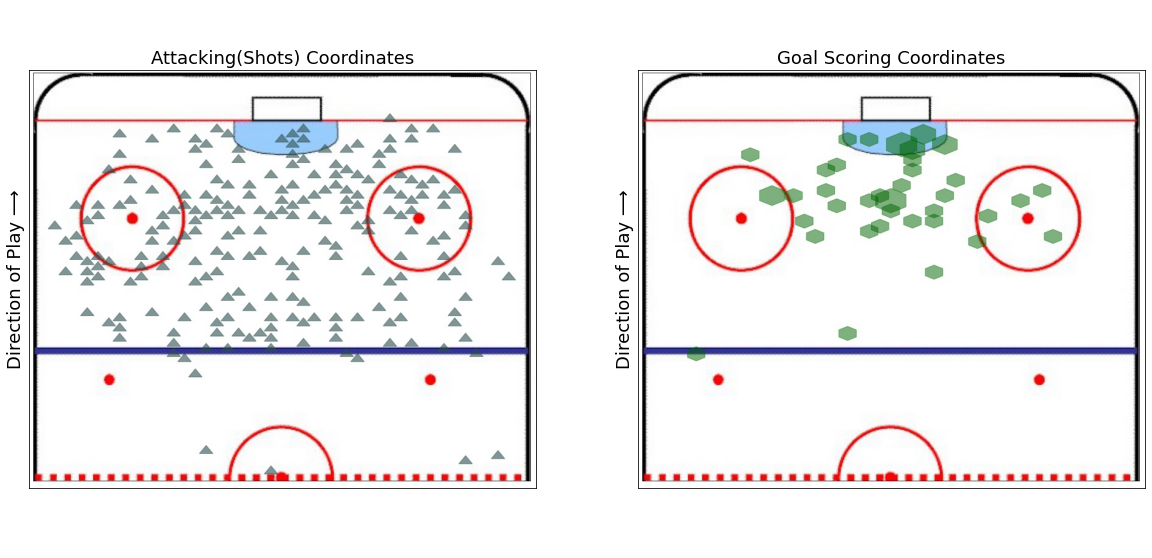

In [8]:
team_a = "Toronto Maple Leafs" 
team_b = "Vancouver Canucks"
filtered_dataframe = display_dataset(team_a, team_b, shot_goals_dataframe_from_json)
shots_from_filtered_dataframe, goals_from_filtered_dataframe = calculate_goal_conversion_ratio\
(team_a, team_b, filtered_dataframe)

shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals\
(shots_from_filtered_dataframe, goals_from_filtered_dataframe)
plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values)

plot_shots_and_goals_comparison(shots_filename = 'Attack_Shots.jpeg', \
                                goals_filename = 'Attack_Goals.jpeg', \
                                plot_title_shots = 'Attacking(Shots) Coordinates', \
                                plot_title_goals = 'Goal Scoring Coordinates' \
                               )

### Defence Positions

### The goal conversion ratio of 'Vancouver Canucks' against 'Toronto Maple Leafs' is 9.74%

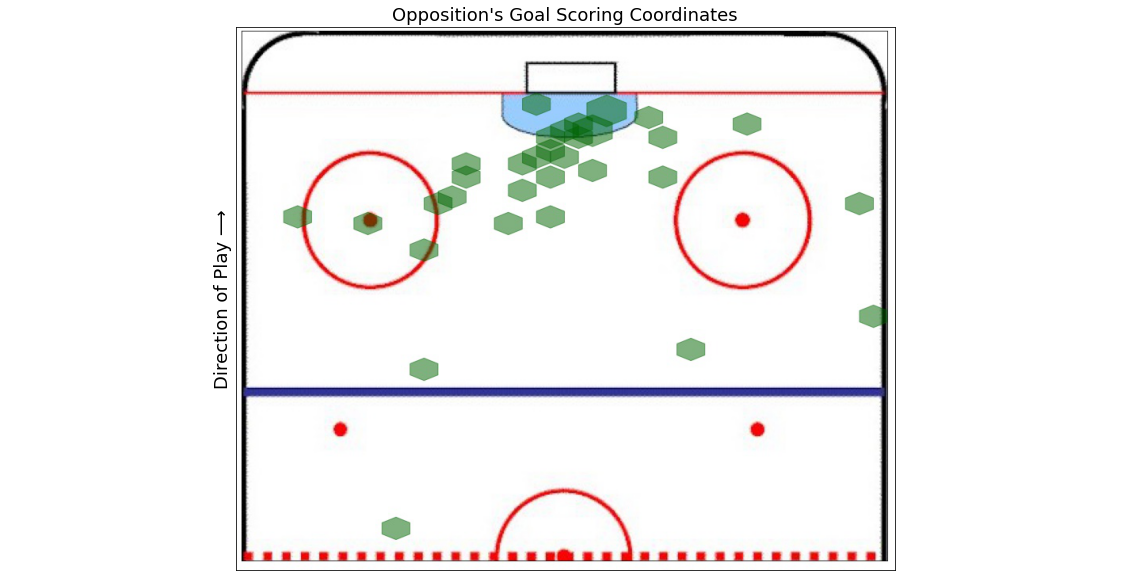

In [9]:
team_b, team_a = team_a, team_b
filtered_dataframe = display_dataset(team_a, team_b, shot_goals_dataframe_from_json)
shots_from_filtered_dataframe, goals_from_filtered_dataframe = calculate_goal_conversion_ratio\
(team_a, team_b, filtered_dataframe)
shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals\
(shots_from_filtered_dataframe, goals_from_filtered_dataframe)
plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values, False)

plot_shots_and_goals_comparison('Attack_Shots.jpeg', 'Attack_Goals.jpeg', \
                                plot_title_shots = '', \
                                plot_title_goals = 'Opposition\'s Goal Scoring Coordinates', \
                                plot_shots = False
                               )

### Player statistics for top 4 players

In [10]:
top_4_players = ['Connor McDavid', 'Nikita Kucherov', 'Sidney Crosby', 'Nathan MacKinnon']

In [11]:
connor_mcdavid_goals = pd.read_csv(r'data/Connor McDavid.csv')
nikita_kucherov_goals = pd.read_csv(r'data/Nikita Kucherov.csv')
sidney_crosby_goals = pd.read_csv(r'data/Sidney Crosby.csv')
nathan_mackinnon_goals = pd.read_csv(r'data/Nathan MacKinnon.csv')
player_df_list = []
player_df_list.append(connor_mcdavid_goals)
player_df_list.append(nikita_kucherov_goals)
player_df_list.append(sidney_crosby_goals)
player_df_list.append(nathan_mackinnon_goals)

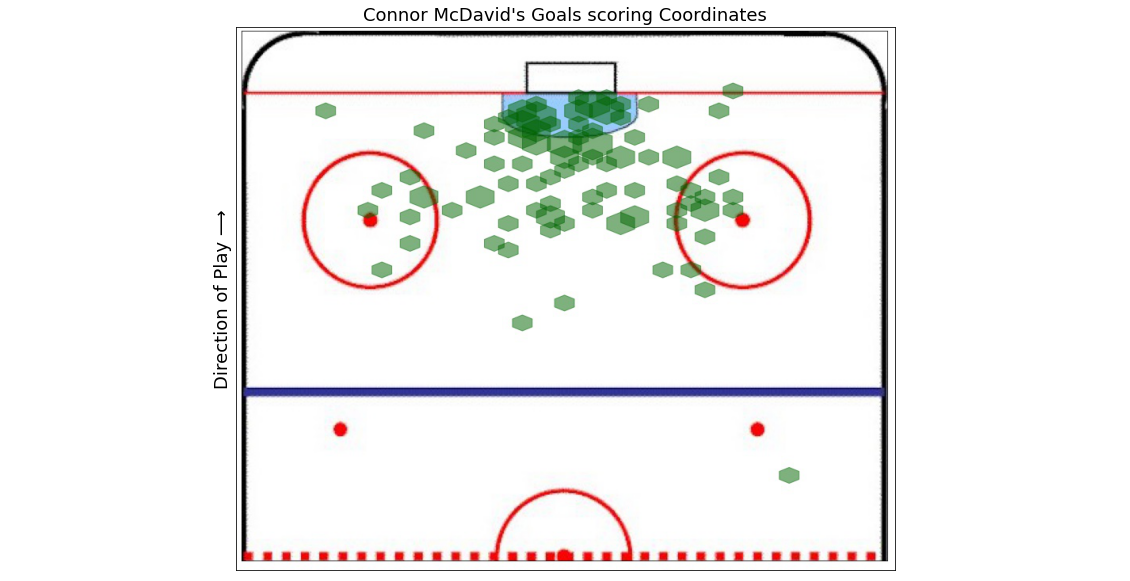

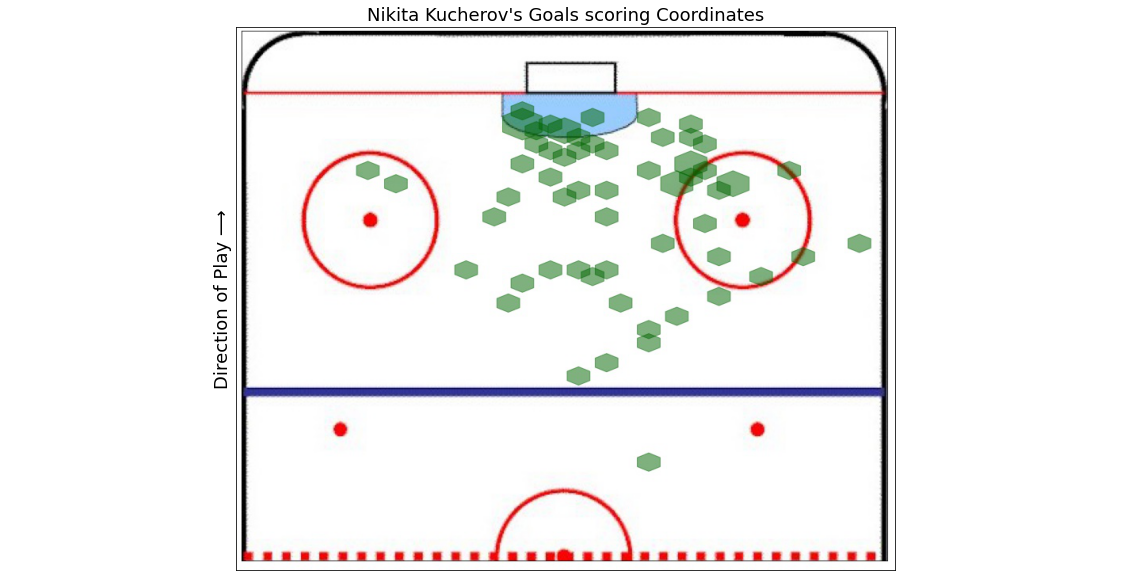

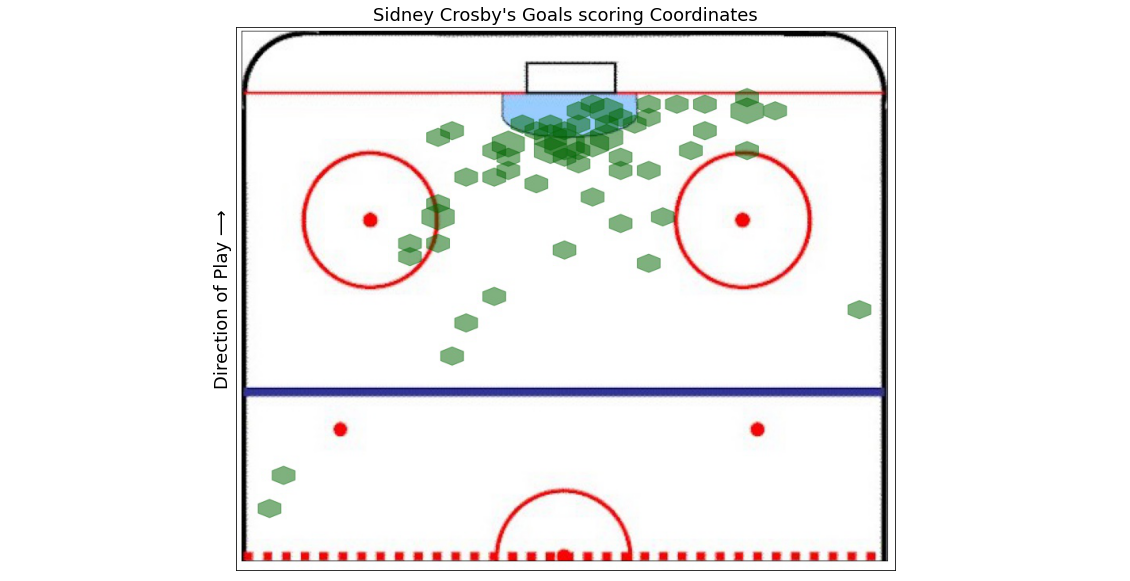

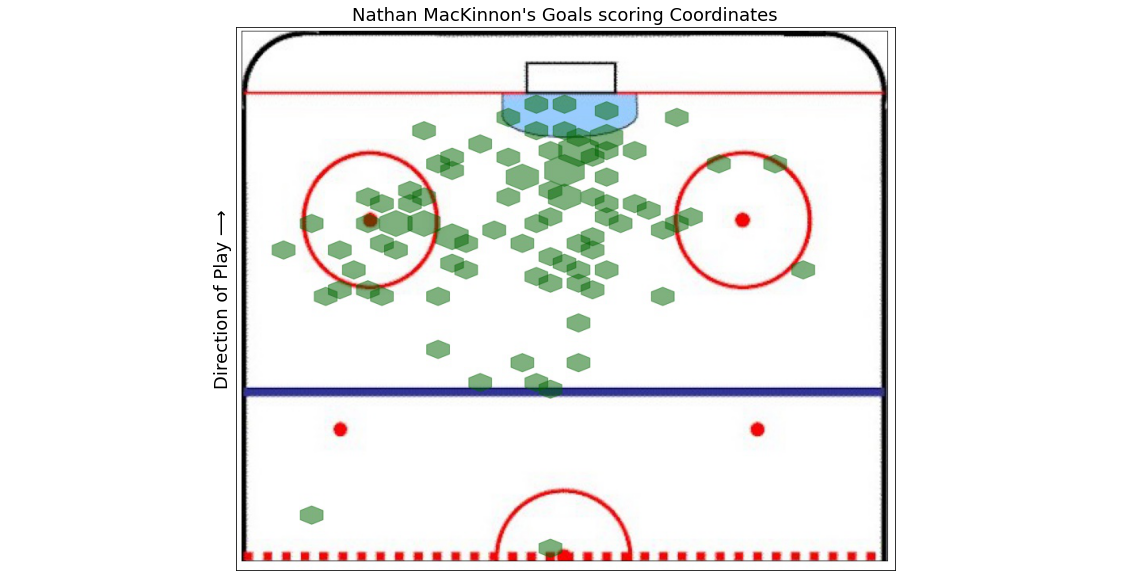

In [12]:
for idx, player_df in enumerate(player_df_list):
    goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals(None, player_df);
    plot_shots_goals_on_rink(None, None, goals_hexbin_offsets, goals_hexbin_values, False)
    plot_shots_and_goals_comparison('Attack_Shots.jpeg', 'Attack_Goals.jpeg', \
                                    plot_title_shots = '', \
                                    plot_title_goals = top_4_players[idx] + "'s Goals scoring Coordinates", \
                                    plot_shots = False)